# Deep Reinforcement Learning for Stock Trading



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-bnvz1h01
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-bnvz1h01
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-txl87o3c/pyfolio_80411decaea74ef0b604776166cc76ac
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-txl87o3c/pyfolio_80411decaea74ef0b604776166cc76ac
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-txl87o3c/elegantrl_e306f0ebaaf74029910460d32115fdce
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-txl87o3c/elegantrl_e306f0ebaaf74029910460d32115fdce
     |████████████████████████████████| 234 kB 14.3 MB/s 
     |████████████████████████████████| 176 kB 79.6 MB/s 
     |████████████████████████████████| 57.6 MB 1.2 MB/s 
     |████████████████████████████████| 1.8 MB 57.9 MB/s 
     |████

In [ ]:
from finrl.apps import config
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [61]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [ ]:
# from config.py end_date is a string
config.END_DATE

'2021-10-31'

In [66]:
import pandas as pd

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
tickers = first_table['Symbol'].values.tolist()

first_table.to_csv("tickers.csv")

In [67]:
df = YahooDownloader(start_date = '2000-01-01',
                     end_date = '2022-1-28',
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.shape

(2487699, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,56.330471,56.464592,48.193848,44.290768,4674353.0,A,0
1,2000-01-03,0.936384,1.004464,0.907924,0.856887,535796800.0,AAPL,0
2,2000-01-03,3.875000,3.937500,3.812500,3.035739,2784800.0,ABC,0
3,2000-01-03,18.515625,18.656250,18.250000,18.250000,185600.0,ABMD,0
4,2000-01-03,15.823756,16.160433,15.599306,9.385103,10635087.0,ABT,0


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature = False
    )

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (5553, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,A,56.330471,56.464592,48.193848,44.290768,4674353.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,44.290768,44.290768,24.209999,0.0
1,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.856887,535796800.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,0.856887,0.856887,24.209999,0.0
2,2000-01-03,ABC,3.875000,3.937500,3.812500,3.035739,2784800.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,3.035739,3.035739,24.209999,0.0
3,2000-01-03,ABMD,18.515625,18.656250,18.250000,18.250000,185600.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,18.250000,18.250000,24.209999,0.0
4,2000-01-03,ABT,15.823756,16.160433,15.599306,9.385103,10635087.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,9.385103,9.385103,24.209999,0.0
5,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274673,7384400.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,16.274673,16.274673,24.209999,0.0
6,2000-01-03,ADI,46.750000,46.937500,44.000000,29.667685,3655600.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,29.667685,29.667685,24.209999,0.0
7,2000-01-03,ADM,10.884354,10.941043,10.770975,6.749476,984753.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,6.749476,6.749476,24.209999,0.0
8,2000-01-03,ADP,42.428928,42.775894,41.189766,25.976387,2698899.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,25.976387,25.976387,24.209999,0.0
9,2000-01-03,ADSK,8.500000,8.656250,8.031250,8.052907,2845600.0,0.0,0.0,47.383834,37.814393,0.0,-66.666667,100.0,8.052907,8.052907,24.209999,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [ ]:
train = data_split(processed_full, '2000-01-01','2020-12-31')
trade = data_split(processed_full, '2021-01-01','2022-01-28')
print(len(train))
print(len(trade))

1944144
98992


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3019,2020-12-30,UNH,347.079987,349.010010,344.470001,340.206543,1866000.0,2.0,1.412417,346.834284,328.020443,55.405886,68.939182,16.468780,335.921114,330.496910,22.77,14.893786
3019,2020-12-30,V,216.000000,220.389999,215.649994,217.026855,8875100.0,2.0,1.765994,215.184932,202.284670,59.209548,263.797567,29.424279,208.439946,203.115749,22.77,14.893786
3019,2020-12-30,VZ,58.830002,58.939999,58.060001,54.956978,18259800.0,2.0,-0.376927,58.951881,54.751595,43.710486,-189.627583,17.673110,56.937598,56.129338,22.77,14.893786
3019,2020-12-30,WBA,39.520000,39.730000,39.200001,37.892838,4194300.0,2.0,0.021573,41.769256,37.031269,50.215147,-34.449436,3.350134,38.597006,37.196320,22.77,14.893786
3019,2020-12-30,WMT,144.880005,145.149994,143.940002,141.923065,6250400.0,2.0,-0.827849,147.682505,140.203590,49.369580,-95.997293,5.379552,145.391426,143.218671,22.77,14.893786


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-01-04,AAPL,133.520004,133.610001,126.760002,128.617111,143301900.0,0.0,3.441189,136.578784,117.958045,56.613051,64.551770,8.436326,124.117176,120.070757,26.969999,37.68459
0,2021-01-04,AMGN,231.250000,231.250000,223.669998,219.858322,3088200.0,0.0,-0.412324,225.892906,215.124499,48.078721,28.665858,1.082054,219.309956,221.072277,26.969999,37.68459
0,2021-01-04,AXP,121.300003,121.800003,116.849998,116.387680,3472100.0,0.0,0.918731,123.077858,112.413924,54.746526,-8.529714,3.618340,117.554113,110.008240,26.969999,37.68459
0,2021-01-04,BA,210.000000,210.199997,202.490005,202.720001,21225600.0,0.0,1.293101,241.661280,205.335718,50.209209,-132.990300,12.708438,220.805333,194.563834,26.969999,37.68459
0,2021-01-04,CAT,183.000000,185.979996,180.250000,178.422699,4078300.0,0.0,2.036097,179.122984,172.662128,59.272576,141.727750,34.923782,174.135921,167.630384,26.969999,37.68459


In [ ]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 368, State Space: 3681


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [ ]:
agent = DRLAgent(env = env_train)

## Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 77         |
|    iterations         | 100        |
|    time_elapsed       | 6          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -23.3      |
|    reward             | 0.16407855 |
|    std                | 1          |
|    value_loss         | 1.02       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 80         |
|    iterations         | 200        |
|    time_elapsed       | 12         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      |

KeyboardInterrupt: ignored

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 6         |
|    time_elapsed    | 3390      |
|    total_timesteps | 21132     |
| train/             |           |
|    actor_loss      | -1.33     |
|    critic_loss     | 3.25      |
|    learning_rate   | 0.001     |
|    n_updates       | 15849     |
|    reward          | 0.4577445 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 6         |
|    time_elapsed    | 6814      |
|    total_timesteps | 42264     |
| train/             |           |
|    actor_loss      | -0.622    |
|    critic_loss     | 2         |
|    learning_rate   | 0.001     |
|    n_updates       | 36981     |
|    reward          | 0.4577445 |
----------------------------------
day: 5282, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 992277.23
total_rewa

### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [ ]:
insample_risk_indicator.turbulence.describe()

count     2893.000000
mean       913.201672
std       1034.407931
min        116.050323
25%        495.121697
50%        696.043021
75%       1042.702853
max      20750.576600
Name: turbulence, dtype: float64

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

6604.518306767491

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value.shape

(269, 2)

In [ ]:
df_account_value.tail()

,date,account_value
264,2022-01-20,1.267200e+06
265,2022-01-21,1.249144e+06
266,2022-01-24,1.255797e+06
267,2022-01-25,1.232377e+06
268,2022-01-26,1.229129e+06


In [ ]:
df_actions.to_csv("actions.csv")

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.213208
Cumulative returns     0.229129
Annual volatility      0.144867
Sharpe ratio           1.411823
Calmar ratio           1.850210
Stability              0.896559
Max drawdown          -0.115234
Omega ratio            1.262647
Sortino ratio          2.076076
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.043240
Daily value at risk   -0.017440
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (268, 8)
Annual return          0.126254
Cumulative returns     0.134789
Annual volatility      0.123857
Sharpe ratio           1.025557
Calmar ratio           1.833311
Stability              0.751119
Max drawdown          -0.068867
Omega ratio            1.186493
Sortino ratio          1.464335
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.964512
Daily value at risk   -0.015100
dtype: float64


In [ ]:
df_account_value.loc[0,'date']

'2021-01-04'

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

'2022-01-26'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (268, 8)


Start date,2021-01-04
End date,2022-01-26
Total months,12
,Backtest
Annual return,21.321%
Cumulative returns,22.913%
Annual volatility,14.487%
Sharpe ratio,1.41
Calmar ratio,1.85
Stability,0.90
Max drawdown,-11.523%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.52,2021-12-29,2022-01-26,NaT,NaN
1,6.29,2021-09-02,2021-10-04,2021-10-25,38
2,5.64,2021-01-20,2021-01-27,2021-02-10,16
3,4.88,2021-11-09,2021-12-01,2021-12-22,32
4,4.30,2021-02-24,2021-03-04,2021-03-12,13


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


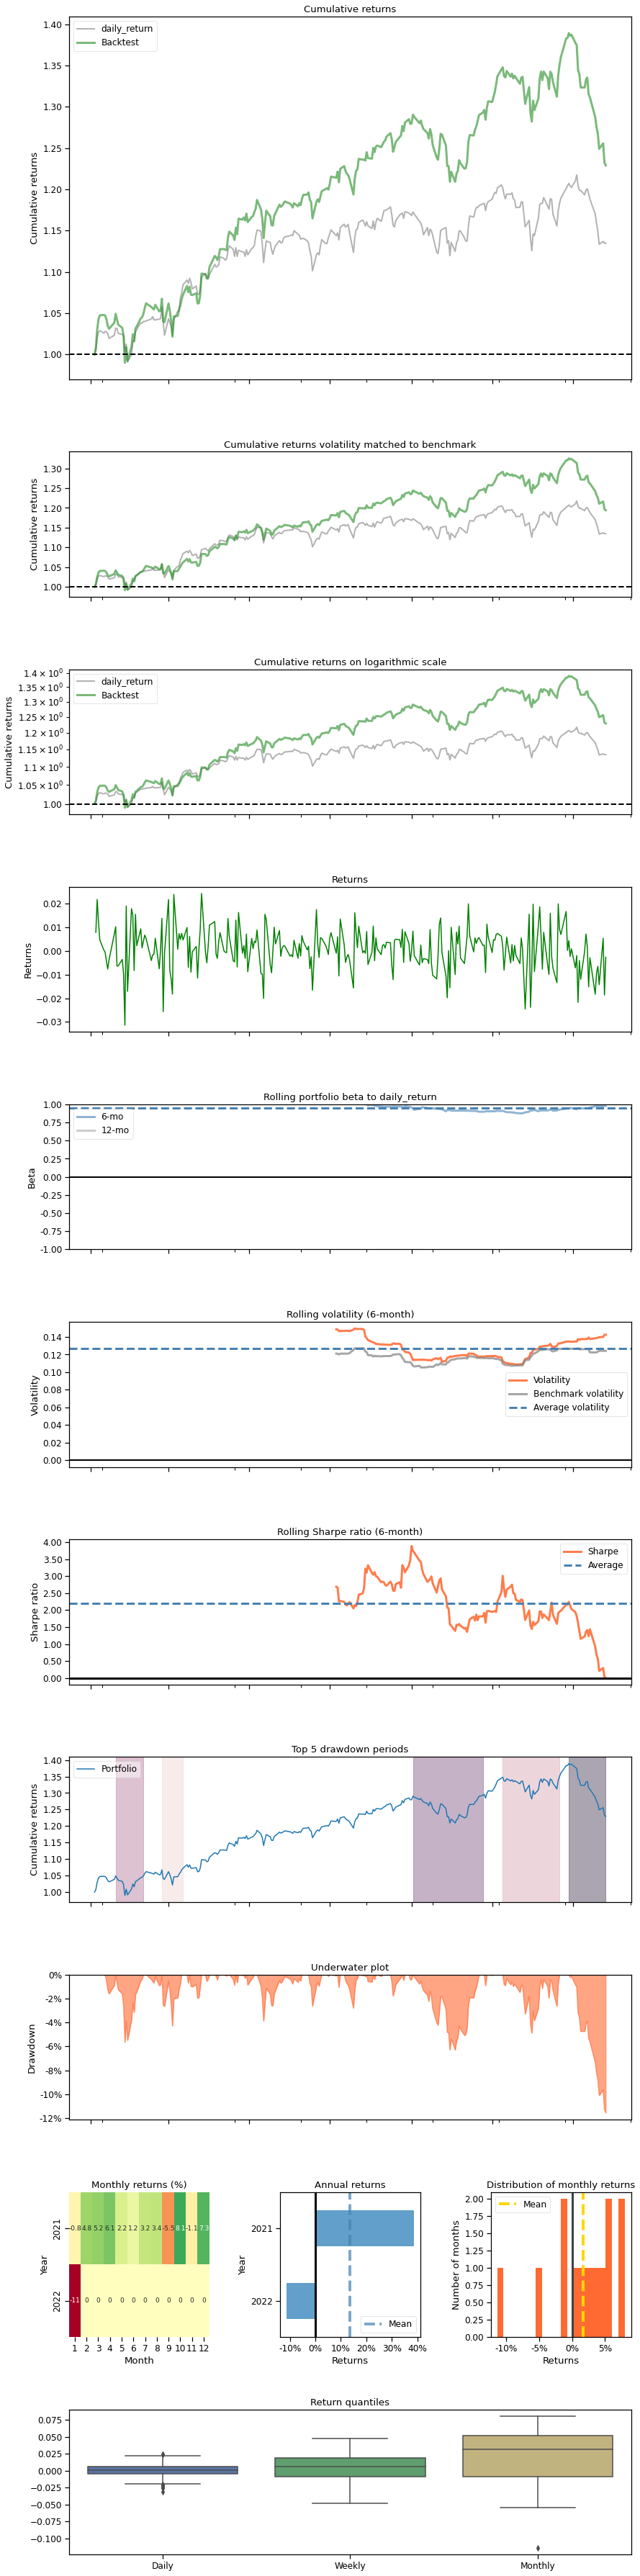

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [48]:
trained_ddpg.save("trained_ddpg.pt")

# Part 8: Deployment


In [105]:
def allocate(
    invest_date="2022-01-30",
    idx="DOW", 
    sp500_path="tickers.csv", 
    ddpg_path="trained_ddpg.zip",
    sac_path="trained.zip",
    money=1000000,
    buy_cost_pct=0.001, 
    sell_cost_pct=0.001
    ):
    """
    money: int
    idx: "DOW" or "SP500"
    actions: dict {ticker:number}
    """

    def get_env(
        trade_data, 
        money, 
        buy_cost_pct, 
        sell_cost_pct
        ):
        """
        trade_data: df
        """

        from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv

        stock_dimension = len(trade_data.tic.unique())
        state_space = 1 + 2 * stock_dimension + \
            len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension

        print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

        env_kwargs = {
            "hmax": 100, 
            "initial_amount": money,
            "buy_cost_pct": buy_cost_pct,
            "sell_cost_pct": sell_cost_pct,
            "state_space": state_space, 
            "stock_dim": stock_dimension, 
            "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
            "action_space": stock_dimension, 
            "reward_scaling": 1e-4
        }

        trade_env = StockTradingEnv(
            df = trade_data, 
            turbulence_threshold = 70, 
            risk_indicator_col='vix', 
            **env_kwargs
            )

        return trade_env

    def download(invest_date, idx, sp500_path):

        # def get_sp500(path):
        #     import pandas as pd
        #     return pd.read_csv(path)['Symbol'].values.tolist()
        
        # from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
        from datetime import date

        today = date.today().strftime("%Y-%m-%d")
        # tickers = get_sp500(sp500_path) if idx == "SP500" else config.DOW_30_TICKER
        # df = YahooDownloader(
        #     start_date = invest_date,
        #     end_date = today,
        #     ticker_list = tickers
        #     ).fetch_data().sort_values(['date','tic'],ignore_index=True)

        df = pd.read_csv("fin_data.csv")
        
        return df[(df['date'] >= invest_date) & (df['date'] <= today)]

    def preprocess(df, invest_date):
        """
        df: dataframe
        """

        from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
        from finrl.finrl_meta.data_processor import DataProcessor
        import itertools
        from datetime import date

        fe = FeatureEngineer(
            use_technical_indicator=True,
            tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
            use_vix=True,
            use_turbulence=True,
            user_defined_feature=False
            )
        
        processed = fe.preprocess_data(df)
        
        list_ticker = processed["tic"].unique().tolist()
        list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
        combination = list(itertools.product(list_date,list_ticker))

        processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
        processed_full = processed_full[processed_full['date'].isin(processed['date'])]
        processed_full = processed_full.sort_values(['date','tic'])

        processed_full = processed_full.fillna(0)
        today = date.today().strftime("%Y-%m-%d")
        # print("Processed shape: ", processed_full.shape)
        # print("Today: ", today)
        # print("Invest date: ", invest_date)
        trade_data = data_split(processed_full, invest_date, today)
        
        # Set turbulence threshold
        data_risk_indicator = processed_full[(processed_full.date <= today) & (processed_full.date >= invest_date)]
        insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

        return trade_data, insample_risk_indicator
    
    import pandas as pd
    # import numpy as np
    # import matplotlib
    # import matplotlib.pyplot as plt

    # %matplotlib inline
    from finrl.apps import config
    from finrl.drl_agents.stablebaselines3.models import DRLAgent, DDPG, SAC
    # from finrl.finrl_meta.data_processor import DataProcessor
    # from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
    # from pprint import pprint

    # Download data from YahooFinance
    df = download(invest_date, idx, sp500_path)
    
    # Pre-Process
    trade_data, _ = preprocess(df, invest_date)

    # Env
    trade_env = get_env(
        trade_data,
        money, 
        buy_cost_pct, 
        sell_cost_pct
        )

    # Trade
    trained = SAC.load("trained")
    portfolio_value, actions = DRLAgent.DRL_prediction(
        model=trained,
        environment=trade_env
        )

    return portfolio_value, actions

In [108]:
values, actions = allocate(money=2000000, invest_date="2019-01-21")

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1013, 8)
Successfully added vix
Successfully added turbulence index
(29377, 19)
Stock Dimension: 29, State Space: 291
hit end!


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1012, 8)


Start date,2018-01-22
End date,2022-01-27
Total months,48
,Backtest
Annual return,4.816%
Cumulative returns,20.813%
Annual volatility,20.236%
Sharpe ratio,0.33
Calmar ratio,0.14
Stability,0.32
Max drawdown,-33.636%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.64,2020-02-06,2020-04-01,2021-03-08,283
1,18.69,2018-10-03,2018-12-24,2019-02-25,104
2,8.95,2018-01-26,2018-03-23,2018-08-27,152
3,8.31,2021-08-12,2021-12-01,2022-01-03,103
4,7.71,2019-03-01,2019-05-31,2019-06-24,82


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


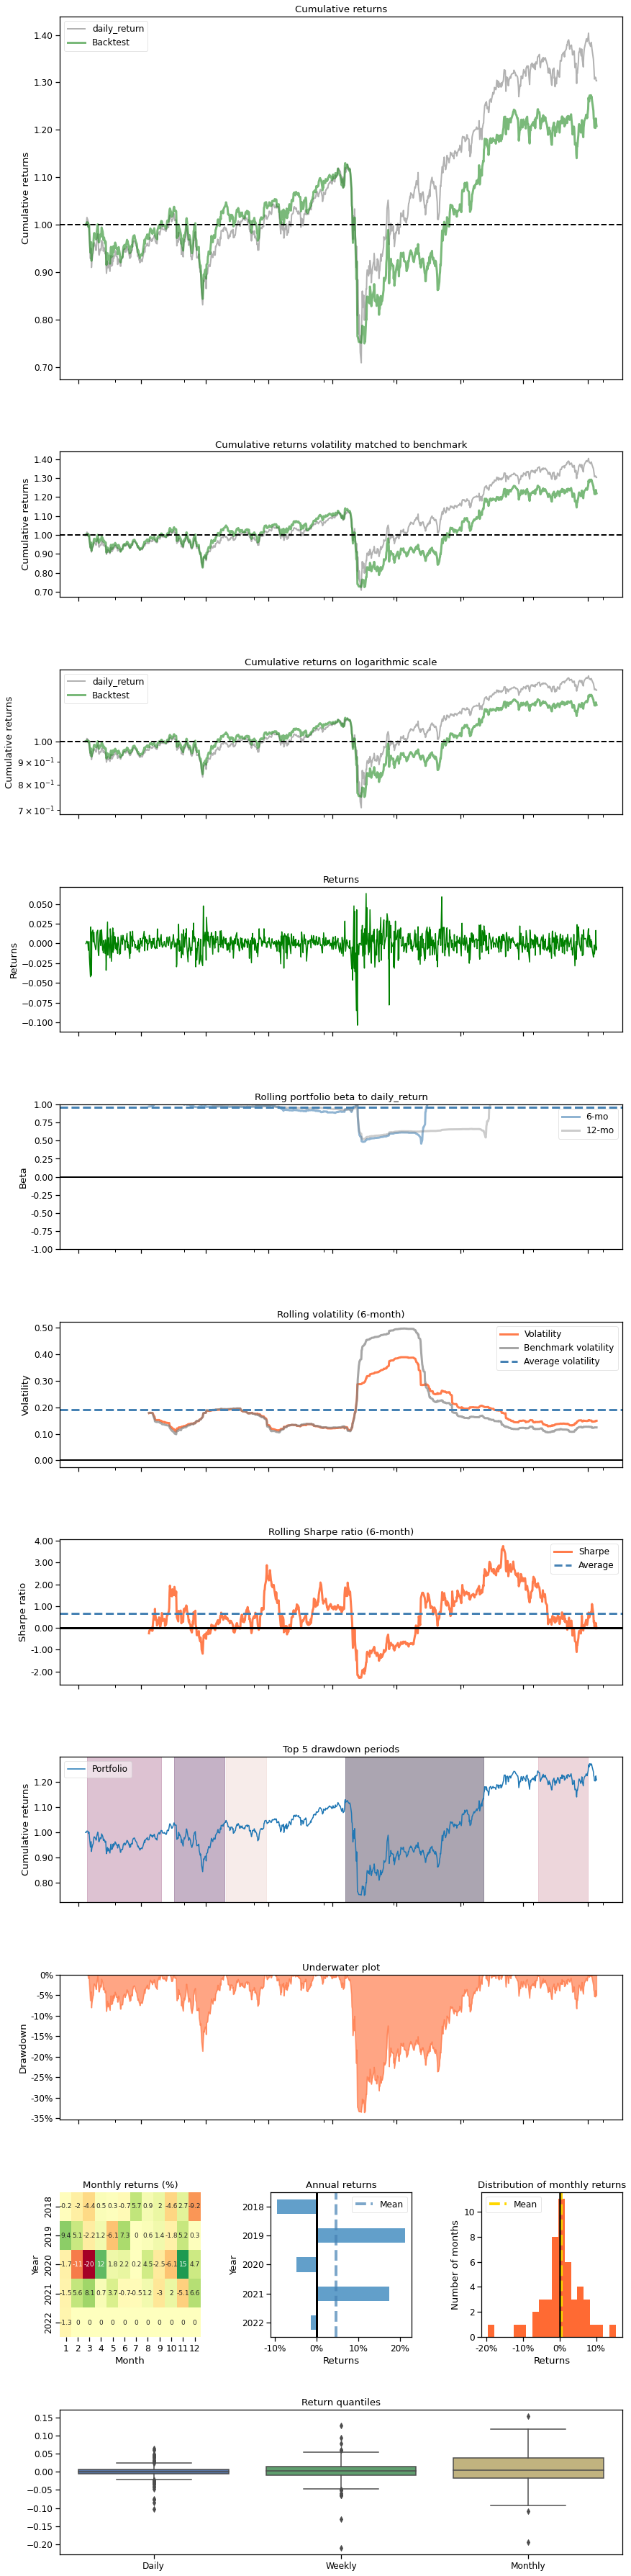

In [110]:
print("==============Compare to DJIA===========")
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(
    values, 
    baseline_ticker = '^DJI', 
    baseline_start = values.loc[0,'date'],
    baseline_end = values.loc[len(values)-1,'date']
    )

In [ ]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from copy import deepcopy
import pyfolio

def plot_returns(
    values,
    baseline_start,
    baseline_end
    ):
    df = deepcopy(values)
    df["date"] = pd.to_datetime(df["date"])
    test_returns = get_daily_return(df, value_col_name="account_value")

    baseline_df = get_baseline(
        ticker="^DJI", start=baseline_start, end=baseline_end
    )

    baseline_df["date"] = pd.to_datetime(baseline_df["date"], format="%Y-%m-%d")
    baseline_df = pd.merge(df[["date"]], baseline_df, how="left", on="date")
    baseline_df = baseline_df.fillna(method="ffill").fillna(method="bfill")
    baseline_returns = get_daily_return(baseline_df, value_col_name="close")

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )

In [98]:
actions.to_csv("actions.csv")

In [70]:
def download(invest_date):

    def get_sp500(path):
        import pandas as pd
        return pd.read_csv(path)['Symbol'].values.tolist()
    
    from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
    from datetime import date
    from finrl.apps import config

    today = date.today().strftime("%Y-%m-%d")
    tickers = config.DOW_30_TICKER
    df = YahooDownloader(
        start_date = invest_date,
        end_date = today,
        ticker_list = tickers
        ).fetch_data().sort_values(['date','tic'],ignore_index=True)
    
    return df

download("2000-01-01").to_csv("fin_data.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********